In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import math
import random

from skimage.io import imread
from skimage.io import imshow
import skimage.transform as trans
from skimage import data, img_as_float
from skimage import exposure, color, data, restoration
from skimage.exposure import match_histograms
import skimage.transform as trans

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.utils import resample


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
input_path = 'Alzheimer_s Dataset/train'
categories = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
print(categories)
#List containing images in its np.array
images = []
classImages = []

#Number of images of each category
numberofimages = []

#similar to rmarkdown to get file directories
for category in categories:
    data_path = os.path.join(input_path, category)
    numberofimages.append(len(os.listdir(data_path)))
    for file in os.listdir(data_path):
        image_paths = os.path.join(data_path, file) #image in this case refers to title of the image
        image = imread(image_paths, as_gray=True) #reads an image, imread - image + read and grayscales all images
        images.append(image)


['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']


In [3]:
print(numberofimages)

[2560, 1792, 717, 52]


In [4]:
NonDemented = images[0:2560]
VeryMildDemented = images[2560:4352]
MildDemented = images[4352:5069]
ModerateDemented = images[5069:]

lst = [NonDemented, VeryMildDemented, MildDemented, ModerateDemented]

In [5]:
#Non-square, so we should change it to a square to its easier to apply rotation functions
NonDemented[0].shape

(208, 176)

for cat in lst:
    for idx in range(len(cat)):
        cat[idx] = trans.resize(cat[idx], (176, 176))

In [6]:
#Check new dimensions
NonDemented[0].shape

(208, 176)

In [7]:
print(len(MildDemented), len(ModerateDemented),len(NonDemented),len(VeryMildDemented))

717 52 2560 1792


In [8]:
plt.style.use('seaborn')

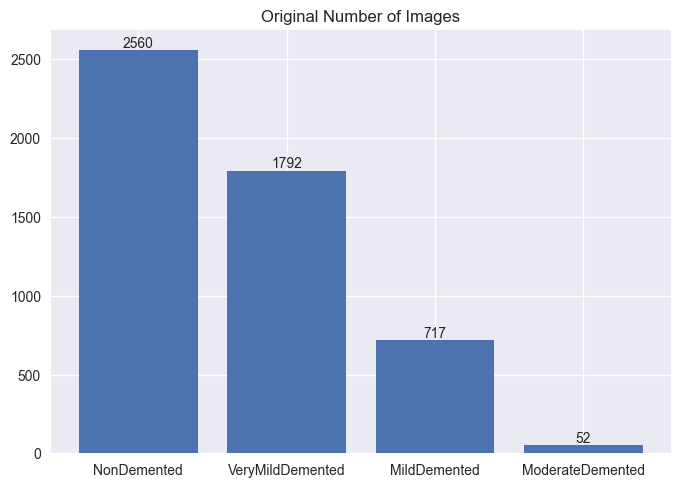

In [9]:
barplot = plt.bar(categories, numberofimages)
plt.title('Original Number of Images')
plt.bar_label(barplot , labels = numberofimages)
plt.show()

In [10]:
#check if all data-set has the same dimensions
dim = images[0].shape
sum_of_incorrect = 0
for i in images:
    if i.shape != dim:
        sum_of_incorrect+=1
print(sum_of_incorrect)

0


In [11]:
#Data Augmentations of MildDementd and ModerateDemented
new_ModerateDemented = []
for i in ModerateDemented:
  new_ModerateDemented.append(trans.rotate(i, 15))#rotate 30 degrees counter clockwise 
  new_ModerateDemented.append(trans.rotate(i, 345))#rotate 30 degrees clockwise     
  new_ModerateDemented.append(trans.rotate(i, 5))#rotate 5 degrees counterclockwise 
  new_ModerateDemented.append(trans.rotate(i,355))#rotate 90 degrees clockwise then resize
  new_ModerateDemented.append(trans.rotate(i, 10))#rotate 120 degrees counter clockwise   
  new_ModerateDemented.append(trans.rotate(i, 350))#rotate 120 degrees clockwise  
  new_ModerateDemented.append(trans.rotate(i, 8))#rotate 30 degrees counter clockwise 
  new_ModerateDemented.append(trans.rotate(i, 362))#rotate 30 degrees counter clockwise 
  new_ModerateDemented.append(trans.rotate(i[::-1], 180)) #Horizontal rotation

print(len(new_ModerateDemented))#new data points

ModerateDemented += new_ModerateDemented#added new data into ModerateDemented
numberofimages[3] += len(new_ModerateDemented)#updated numbers for image
print(numberofimages) #Number of new images for dataset 1

468
[2560, 1792, 717, 520]


In [12]:
new_ModerateDemented[1].shape

(208, 176)

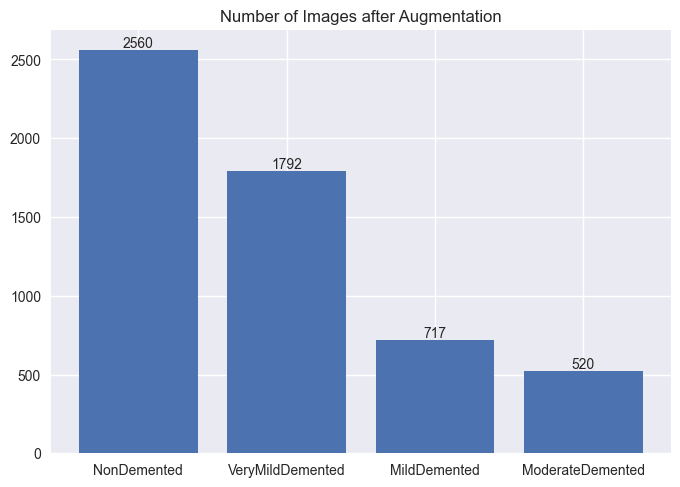

In [13]:
#Data after augmentation
barplot = plt.bar(categories, numberofimages)
plt.title('Number of Images after Augmentation')
plt.bar_label(barplot , labels = numberofimages)
plt.show()

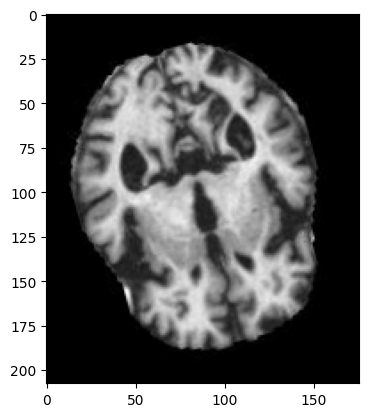

In [14]:
#Showing example of our image augmentation which keeps roughly the similar orientation
plt.style.use('default')
plt.imshow(new_ModerateDemented[0], cmap = 'gray')
plt.show()

Even With augmentation, there is an excessive amount of NonDemented and VeryMildDemented. We can perform downsampling to speed up computations. We will make it around the samples of mild demented + 700 for Non-Demented and +100 for VeryMildDemented. It was done this way so that the dataset so that the dataset is balanced between NonDemented and IsDemented which includes all cases of alzheimer

In [15]:
downsampled_NonDemented = resample(NonDemented, replace= False, n_samples= len(MildDemented) + 600, random_state=9)
downsampled_VeryMildDemented = resample(VeryMildDemented, replace= False, n_samples= len(MildDemented) + 200, random_state= 9)

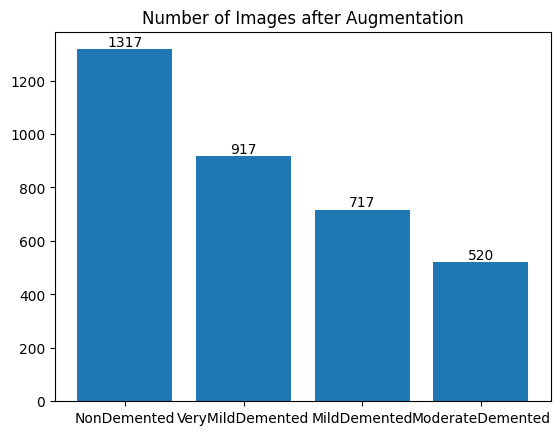

In [16]:
new_numberofimages = [len(downsampled_NonDemented), len(downsampled_VeryMildDemented), len(MildDemented), len(ModerateDemented)]
barplot = plt.bar(categories, new_numberofimages )
plt.title('Number of Images after Augmentation')
plt.bar_label(barplot , labels = new_numberofimages )
plt.show()

In [17]:
new_lst = [downsampled_NonDemented, downsampled_VeryMildDemented, MildDemented, ModerateDemented] #our new lst to refer to for downsized samples

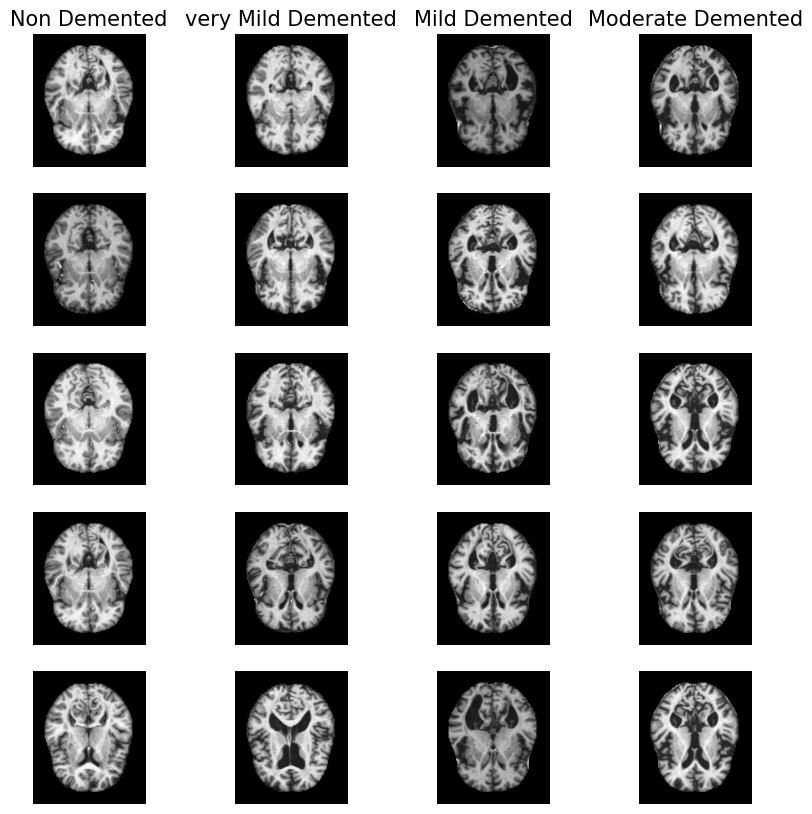

In [18]:
#First 4 pictures to roughly show how each MRI Scan for each category looks like using the original dataset
fig,axes = plt.subplots(5,4, figsize = (10,10))

for i in range(len(lst)):
    for j in range(5):
        img = lst[i][j]
        axes[j,i].imshow(img, cmap = 'gray')
        axes[j,i].axis('off') #turn off axis for each subplot
axes[0,0].set_title('Non Demented', fontsize = 15)
axes[0,1].set_title('very Mild Demented', fontsize = 15)
axes[0,2].set_title('Mild Demented', fontsize = 15)
axes[0,3].set_title('Moderate Demented', fontsize = 15)
plt.show()

The Above picture shows us that some images are darker than others
We can do intensity normalization via adaptive histogram equalization(adaptive to ensure not too contrasted)

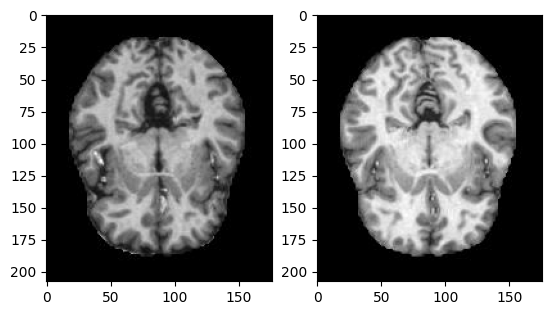

In [19]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(NonDemented[1], cmap = 'gray')
axes[1].imshow(NonDemented[2], cmap = 'gray')
plt.show()

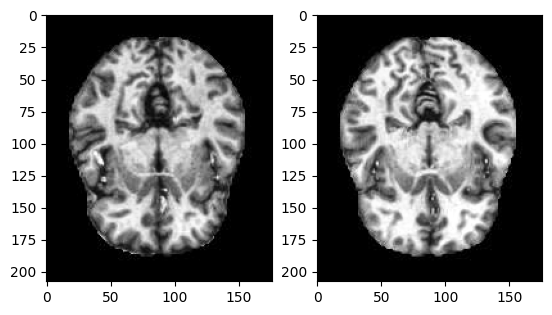

In [20]:
fig, axes = plt.subplots(1,2)
img = NonDemented[1]
img2 = NonDemented[2]

img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.007)
img2_adapteq = exposure.equalize_adapthist(img2, clip_limit= 0.007)


axes[0].imshow(img_adapteq, cmap = 'gray')
axes[1].imshow(img2_adapteq, cmap = 'gray')
plt.show()

In [21]:
for cat in new_lst:
    for imgidx in range(len(cat)):
        cat[imgidx] = exposure.equalize_adapthist(cat[imgidx], clip_limit = 0.007)



Lets now analyse the the pixels of a 'mean' image of 60 images from each class, changing the scale from [0,1]


In [22]:
mean_pixels = []
for cat in new_lst:
    total = 0
    flat = []
    for j in range(30):
        total += cat[j] / 30
        flat.extend(cat[j].flatten())
    mean_pixels.append(flat)

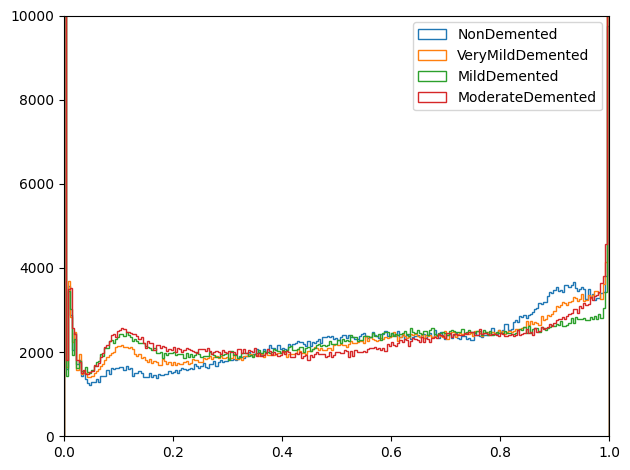

In [23]:
for i in range(len(mean_pixels)):
    plt.hist(mean_pixels[i], bins = 255, histtype = 'step')
    plt.xlim([0,1])
    plt.ylim([0,10000])

plt.legend(categories)
plt.tight_layout()
plt.show()

For NonDemented -- We can can see that there is significantly less dark pixels for the NonDemented. It might be a good idea to use a binary mask filter for classification. Pixel range is approx 0.05 - 0.25 then do feature selection --> We use the TOTAL number of pixels in these ranges to determine whether it is demented or non-demented(actually dont calculate total because its only 1 feature - not good indicator)

In [24]:
newBinaryImages = []
newBinaryImages_flat = []
for cat in new_lst:
    for img in cat:
        img1 = np.array(img)
        #Binary mask
        img1 = np.where((img1 >= 0.06) & (img1<= 0.25), 1,0)
        #img1 = np.where(img1 <= 0.25, 1,0)
        newBinaryImages.append(img1)
        newBinaryImages_flat.append(img1.flatten())

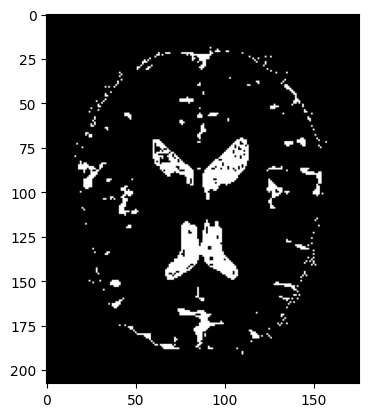

In [25]:
#Image after binary mask application
plt.imshow(newBinaryImages[0], cmap = 'gray')
plt.show()

In [26]:
len(newBinaryImages_flat)

3471

In [27]:
labels = []
for i in range(len(categories)):
    labels.extend(np.repeat(categories[i], new_numberofimages[i]))

In [28]:
classificationLabels = np.where(np.array(labels) == 'NonDemented', 0, 1)
classificationLabels

array([0, 0, 0, ..., 1, 1, 1])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(newBinaryImages_flat, classificationLabels, test_size= 0.25, shuffle=True, random_state= 9)

In [30]:
X_test[0].shape

(36608,)

In [31]:
#Checking if all X_train have same dimensions because needed to debug :(
for i in X_train:
    if len(i) != 36608:
        print('y')

In [32]:
kf = KFold()

In [33]:
logreg = LogisticRegressionCV(cv=kf, random_state= 9)
logreg.fit(X_train,y_train)

LogisticRegressionCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                     random_state=9)

In [34]:
ypred = logreg.predict(X_test)
print(classification_report(ypred, y_test))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       314
           1       0.94      0.92      0.93       554

    accuracy                           0.91       868
   macro avg       0.90      0.91      0.90       868
weighted avg       0.91      0.91      0.91       868



In [35]:
svm = LinearSVC()
svm.fit(X_train, y_train)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [36]:
svmypred = svm.predict(X_test)
print(classification_report(svmypred, y_test))
confusion_matrix(svmypred,y_test)

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       309
           1       0.95      0.92      0.93       559

    accuracy                           0.92       868
   macro avg       0.91      0.92      0.91       868
weighted avg       0.92      0.92      0.92       868



array([[283,  26],
       [ 46, 513]], dtype=int64)

In [70]:
baseImages = []
for cat in new_lst:
    for image in cat:
        baseImages.append(image.flatten())

In [71]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(baseImages, classificationLabels)

In [72]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_train2 = lda.fit_transform(X_train2, y_train2)
X_test2 = lda.transform(X_test2)

In [ ]:
X_train2

In [73]:
svmsecond = LinearSVC()
svm.fit(X_train2,y_train2)
secondsvmpred = svm.predict(X_test2)
print(classification_report(secondsvmpred, y_test2))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       319
           1       0.90      0.91      0.91       549

    accuracy                           0.88       868
   macro avg       0.88      0.87      0.87       868
weighted avg       0.88      0.88      0.88       868



c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [74]:
logreg2 = LogisticRegressionCV(cv=kf, random_state= 9)
logreg2.fit(X_train2,y_train2)

logreg2ypred = logreg2.predict(X_test2)
print(classification_report(logreg2ypred, y_test2))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       319
           1       0.90      0.91      0.91       549

    accuracy                           0.88       868
   macro avg       0.88      0.87      0.87       868
weighted avg       0.88      0.88      0.88       868



In [62]:
baseImages[0]

array([[0.0018406 , 0.0018406 , 0.0018406 , ..., 0.0018406 , 0.0018406 ,
        0.0018406 ],
       [0.0018406 , 0.0018406 , 0.0018406 , ..., 0.0018406 , 0.0018406 ,
        0.0018406 ],
       [0.0018406 , 0.0018406 , 0.0018406 , ..., 0.0018406 , 0.0018406 ,
        0.00177925],
       ...,
       [0.0018406 , 0.0018406 , 0.0018406 , ..., 0.0018406 , 0.0018406 ,
        0.0018406 ],
       [0.0018406 , 0.0018406 , 0.0018406 , ..., 0.00177925, 0.0018406 ,
        0.0018406 ],
       [0.0018406 , 0.0018406 , 0.0018406 , ..., 0.0018406 , 0.0018406 ,
        0.0018406 ]])

In [79]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
cnnModel = keras.Sequential([])